In [1]:
import numpy as np
import cytnx as ct
import matplotlib.pyplot as plt

In [2]:
J=1
h=0
Lmax=10
beta = 1/np.geomspace(2.26,2.38,50)

In [3]:
def get_delta(beta,h):
    delta_t = ct.zeros((2,2,2,2))
    delta_t[0,0,0,0] = np.exp(beta*h)
    delta_t[1,1,1,1] = np.exp(-beta*h)
    delta_ut = ct.UniTensor(delta_t, rowrank=2)
    return delta_ut

In [4]:
def merge_y(T1,T2):
    net = ct.Network('./network/merge_y.net')
    net.PutUniTensors(['T1','T2'],[T1,T2])
    L2 = net.Launch()
    L2.combineBonds([1,2])
    L2.combineBonds([3,4])
    return L2

In [5]:
def get_T(J,beta,delta_ut):
    W=(np.exp(np.array([[J*beta, -J*beta],[-J*beta,J*beta]])))
    W_t = ct.from_numpy(W)
    S_t,U_t,Vd_t = ct.linalg.Svd(W_t)
    M_t = (U_t @ ct.linalg.Diag(S_t.Pow(0.5)))
    M_ut = ct.UniTensor(M_t,rowrank=1)
    net = ct.Network('./network/transfer.net')
    net.PutUniTensors(['delta','M1','M2','M3','M4'],
                  [delta_ut,M_ut,M_ut,M_ut,M_ut])
    return net.Launch()

In [6]:
def merge_x(T1,T2):
    net = ct.Network('./network/merge_x.net')
    net.PutUniTensors(['T1','T2'],[T1,T2])
    L2 = net.Launch()
    L2.combineBonds([0,1])
    L2.combineBonds([4,5])
    return L2

In [7]:
%%time
TM = {}
L = {}
u = {}
xi = {}
E = {}
for i in range(2,Lmax+1):
    xi[i] = []
for i in beta:
    delta_ut = get_delta(i,h)
    T_ut = get_T(J,i,delta_ut)
    T_x2 = merge_x(T_ut,T_ut)
    for j in range(2,Lmax+1):
        if j==2:
            L[j]=merge_y(T_x2,T_x2)
        else:
            L[j]=merge_y(L[j-1],T_x2)
        TM[j] = L[j].get_block().numpy()
        TM[j] = np.trace(TM[j],axis1=0,axis2=3)
        u[j],_ = np.linalg.eigh(TM[j])
        u[j] = u[j][::-1]
        E[j] = -np.log(u[j])
        xi[j].append(1/(E[j][1]-E[j][0]))

CPU times: user 2min 36s, sys: 1min 28s, total: 4min 5s
Wall time: 1min 29s


In [8]:
for i in range(2,Lmax+1):
    xi[i]=np.array(xi[i])
    xi[i]=xi[i]/i

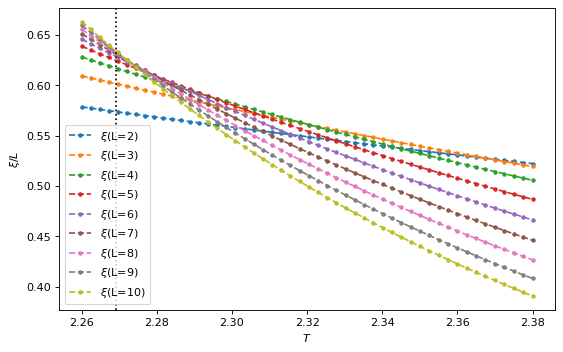

In [9]:
plt.figure(figsize=(8,5),dpi=80)
for i in range(2,Lmax+1):
    plt.plot(1/beta,xi[i],'.--',label='$\\xi$(L=%d)' %i)
#for i in range(3,Lmax+1):
    #plt.plot(1/beta[np.argmin(np.abs(xi[i]-xi[i-1]))],xi[i][np.argmin(np.abs(xi[i]-xi[i-1]))],'r.')
plt.axvline(x=2/np.log(1+np.sqrt(2)),ls=':',c='k')
plt.legend()
plt.xlabel('$T$')
plt.ylabel('$\\xi/L$')
plt.show()

# Conpare with x=1

In [10]:
Lmax = 2

In [11]:
%%time
TM2 = {}
L2 = {}
u2 = {}
xi2 = {}
E2 = {}
for i in range(2,Lmax+1):
    xi2[i] = []
for i in beta:
    delta_ut = get_delta(i,h)
    T_ut = get_T(J,i,delta_ut)
    T_x2 = merge_x(T_ut,T_ut)
    for i in range(2,Lmax+1):
        if i==2:
            L2[i]=merge_y(T_x2,T_x2)
        else:
            L2[i]=merge_y(L[i-1],T_x2)
    for i in range(2,Lmax+1):
        TM2[i] = L2[i].get_block().numpy()
        TM2[i] = np.trace(TM2[i],axis1=0,axis2=3)
        u2[i],_ = np.linalg.eigh(TM2[i])
        u2[i] = u2[i][::-1]
        E2[i] = -np.log(u2[i])
        xi2[i].append(1/(E2[i][1]-E2[i][0]))

CPU times: user 516 ms, sys: 78.1 ms, total: 594 ms
Wall time: 235 ms


In [12]:
for i in range(2,Lmax+1):
    xi2[i]=np.array(xi2[i])
    xi2[i]=xi2[i]/i

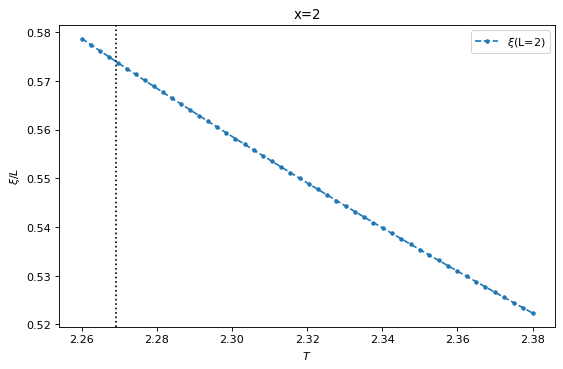

In [13]:
plt.figure(figsize=(8,5),dpi=80)
for i in range(2,Lmax+1):
    plt.plot(1/beta,xi2[i],'.--',label='$\\xi$(L=%d)' %i)
#for i in range(3,Lmax+1):
    #plt.plot(1/beta[np.argmin(np.abs(xi[i]-xi[i-1]))],xi[i][np.argmin(np.abs(xi[i]-xi[i-1]))],'r.')
plt.axvline(x=2/np.log(1+np.sqrt(2)),ls=':',c='k')
plt.legend()
plt.xlabel('$T$')
plt.ylabel('$\\xi/L$')
plt.title('x=2')
plt.show()

In [14]:
%%time
TM = {}
L = {}
u = {}
xi = {}
E = {}
for i in range(2,Lmax+1):
    xi[i] = []
for i in beta:
    delta_ut = get_delta(i,h)
    T_ut = get_T(J,i,delta_ut)
    for i in range(2,Lmax+1):
        if i==2:
            L[i]=merge_y(T_ut,T_ut)
        else:
            L[i]=merge_y(L[i-1],T_ut)
    for i in range(2,Lmax+1):
        TM[i] = L[i].get_block().numpy()
        TM[i] = np.trace(TM[i],axis1=0,axis2=3)
        u[i],_ = np.linalg.eigh(TM[i])
        u[i] = u[i][::-1]
        E[i] = -np.log(u[i])
        xi[i].append(1/(E[i][1]-E[i][0]))

CPU times: user 422 ms, sys: 78.1 ms, total: 500 ms
Wall time: 196 ms


In [15]:
for i in range(2,Lmax+1):
    xi[i]=np.array(xi[i])
    xi[i]=xi[i]/i

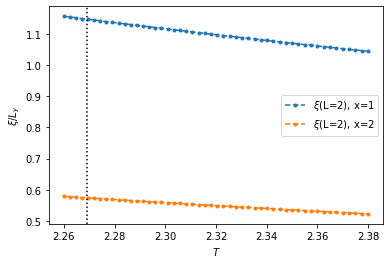

In [16]:
for i in range(2,Lmax+1):
    plt.plot(1/beta,xi[i],'.--',label='$\\xi$(L=%d), x=1' %i)
    plt.plot(1/beta,xi2[i],'.--',label='$\\xi$(L=%d), x=2' %i)
#for i in range(3,Lmax+1):
    #plt.plot(1/beta[np.argmin(np.abs(xi[i]-xi[i-1]))],xi[i][np.argmin(np.abs(xi[i]-xi[i-1]))],'r.')
plt.axvline(x=2/np.log(1+np.sqrt(2)),ls=':',c='k')
plt.legend()
plt.xlabel('$T$')
plt.ylabel('$\\xi/L_y$')
plt.show()

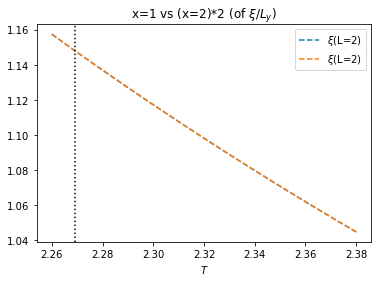

In [17]:
for i in range(2,Lmax+1):
    plt.plot(1/beta,xi[i],'--',label='$\\xi$(L=%d)' %i)
    plt.plot(1/beta,xi2[i]*2,'--',label='$\\xi$(L=%d)' %i)
#for i in range(3,Lmax+1):
    #plt.plot(1/beta[np.argmin(np.abs(xi[i]-xi[i-1]))],xi[i][np.argmin(np.abs(xi[i]-xi[i-1]))],'r.')
plt.axvline(x=2/np.log(1+np.sqrt(2)),ls=':',c='k')
plt.legend()
plt.xlabel('$T$')
plt.title('x=1 vs (x=2)*2 (of $\\xi/L_y$)')
plt.show()